In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import requests
import io

In [5]:
train=pd.read_csv( "https://github.com/huynhthanh98/ML/raw/ML-2022/Lab03/bt_train.csv")
valid=pd.read_csv( "https://github.com/huynhthanh98/ML/raw/ML-2022/Lab03/bt_valid.csv")

In [6]:
train.head()

,x1,x2,label
0,55.808717,54.602061,0
1,50.882672,52.736342,0
2,53.196444,44.208365,0
3,54.727839,60.406845,0
4,49.771372,48.405605,0


In [7]:
train['label'].unique()

array([0, 1, 2])

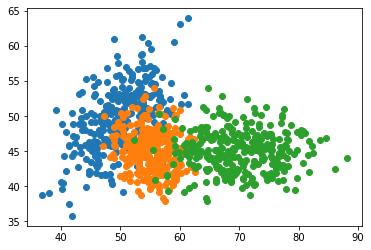

In [8]:
x1_train = train['x1'].values
x2_train = train['x2'].values
y_train = train['label'].values

plt.scatter(x1_train[y_train == 0], x2_train[y_train==0])
plt.scatter(x1_train[y_train == 1], x2_train[y_train==1])
plt.scatter(x1_train[y_train == 2], x2_train[y_train==1])

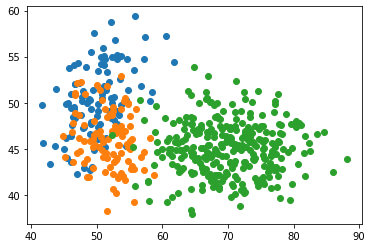

In [9]:
x1_valid = valid['x1'].values
x2_valid = valid['x2'].values
y_valid = valid['label'].values

plt.scatter(x1_valid[y_valid == 0], x2_valid[y_valid==0])
plt.scatter(x1_valid[y_valid == 1], x2_valid[y_valid==1])
plt.scatter(x1_train[y_train == 2], x2_train[y_train==1])

In [10]:
#read data
X_train_ori=train.values[:,:-1]
y_train=train.values[:,-1].reshape(-1, 1)
X_valid_ori=valid.values[:,:-1]
y_valid=valid.values[:,-1].reshape(-1, 1)

### NORMALIZE FEATURE AND ONEHOT ENDCODING TARGET

In [11]:
def onehot(y_train):
    nb_classes = len(np.unique(y_train))
    targets = y_train.reshape(-1)
    one_hot_targets = np.eye(nb_classes)[targets.astype(int)]
    return one_hot_targets 

In [12]:
def normalization(X_train, y_train):
    X_mean = X_train.mean(axis=0)
    X_std = X_train.std(axis=0) 
    X_train_norm=(X_train-X_train.mean(axis=0))/X_train.std(axis=0)
    X_train_full=np.concatenate([X_train_norm, 
                           np.ones([X_train.shape[0], 1])], axis=-1)
    
    return (X_train_norm, X_train_full)

In [13]:
X_train_norm, X_train = normalization(X_train_ori, y_train)
y_train_onehot=onehot(y_train)

In [14]:
X_valid_norm, X_valid = normalization(X_valid_ori, y_valid)
y_valid_onehot=onehot(y_valid)

### MULTIPLE LOGISTICS REGRESSION USING SOFTMAX


**- Ta cần dự đoán phân phối:**  $P_{\theta}(c | x)$; Với c in {1,2,3}  

**- Giả thiết**: 
$P(y^{(i)} = c  | x^{(i)}, \theta) = \frac{exp(\theta^{(c)\top} * x^{(i)})}{\sum_{j=0}^{2} exp(\theta^{(j)\top} * x^{(i)})} $ với c in {1,2,3} 

**- Hàm mất mát**: (Cross Entropy Loss)

$J(\theta) = - \frac{1}{N}\sum_{i=1}^{N}\sum_{c = 0}^{2} 1\{y^{y^{(i)}=c}\} log(\frac{exp(\theta^{(c)\top} * x^{(i)})}{\sum_{j=0}^{2} exp(\theta^{(j)\top} * x^{(i)})})$
 
**- Gradient Descent:** 

$\Delta_{\theta^{(k)}} J(\theta) = - \sum_{i = 1}^{N}[ x_{i}(1\{y_{(i)}=c\}  - P(y^{(i)} = c  | x^{(i)}, \theta)]   $   

In [15]:
def softmax(Z):
    return np.exp(Z)*1/np.sum(np.exp(Z), axis=1).reshape(-1,1)

In [16]:
# X = X * theta
def calculate_Z(X, theta):
    return X*theta # shape (n, p+1) * (p+1, k)

In [17]:
def initialize_parameters(X, y_train):
    # X (n, p+1), num_clas = c
    num_class=len(np.unique(y_train))
    theta = np.zeros([num_class, X.shape[1]]) #shape (c, p+1) 
    return theta 

In [18]:
def one_forward_pass(X, theta):
    Z = np.dot(X, theta.T)  # shape (n, p+1) * (p+1)*c = (n, c)
    y_hat_matrix = softmax(Z) # shape: (n, c) 
    return y_hat_matrix # shape (n, c) 

**- Gradient Descent:** 

$\Delta_{\theta^{(k)}} J(\theta) = - \sum_{i = 1}^{N}[ x_{i}(1\{y_{(i)}=c\}  - P(y^{(i)} = c  | x^{(i)}, \theta)]   $   

In [19]:
def calc_grad(X, y_matrix_onehot, y_hat_matrix):
    error=y_hat_matrix-y_matrix_onehot #(n, c) ; X (n, p+1)
    classes=np.unique(y_train).astype(int)
    grads=np.array([np.sum(X * error[:, i].reshape(-1,1), axis=0) for i in classes])
    # 1 c la 1 rows 
    return grads


**- Hàm Loss**: (Cross Entropy Loss)

$J(\theta) = - \frac{1}{N}\sum_{i=1}^{N}\sum_{c = 0}^{2} 1\{y^{y^{(i)}=c}\} log(\frac{exp(\theta^{(c)\top} * x^{(i)})}{\sum_{j=0}^{2} exp(\theta^{(j)\top} * x^{(i)})})$ 

In [20]:
def loss_calc(y_onehot, y_hat_matrix): #(n, c)  
    N=y_onehot.shape[0]
    return -1/N*np.sum(np.sum(y_onehot*np.log(y_hat_matrix), axis=1))

In [21]:
y_hat = np.array([0.14, 0., .8])
np.argmax(y_hat)

2

In [22]:
def get_accuracy(y_train, y_predict_score_matrix):
    '''
    y_predict_score_matrix: result is list if float in (0,1)
    '''
    y_predict_onehot=np.argmax(y_predict_score_matrix, axis=1)
    acc_score=np.mean((y_train.reshape(-1)==y_predict_onehot))
    return acc_score

In [58]:
theta=initialize_parameters(X_train,y_train)
n_iters = 100000
learning_rate=0.001 

for i in range(n_iters): 
    y_matrix_onehot=onehot(y_train) 
    y_train_hat_matrix=one_forward_pass(X_train, theta)
    loss_train=loss_calc(y_train_onehot, y_train_hat_matrix) 
    grads=calc_grad(X_train, y_matrix_onehot, y_train_hat_matrix)
    theta -= learning_rate*grads 
    
    if i%10000==0:
        y_valid_predict_score_matrix=one_forward_pass(X_valid, theta)
        loss_val=loss_calc(y_valid_onehot, y_valid_predict_score_matrix) 
        
        train_acc=get_accuracy(y_train, y_train_hat_matrix) 
        valid_acc=get_accuracy(y_valid, y_valid_predict_score_matrix) 
        
        print("Iter: {}, Loss Train: {:.4f} - Loss Valid: {:.4f} | Train Acc {:.4f} - Valid Acc {:.4f} ".format(
            i, 
            loss_train, 
            loss_val,
            train_acc, 
            valid_acc, 
            )
         )
    # printing the Loss and 
print("tham số Theta đọc được: ", theta)

Iter: 0, Loss Train: 1.0986 - Loss Valid: 0.9190 | Train Acc 0.3333 - Valid Acc 0.6567 
Iter: 10000, Loss Train: 0.2876 - Loss Valid: 1.0009 | Train Acc 0.8856 - Valid Acc 0.7000 
Iter: 20000, Loss Train: 0.2876 - Loss Valid: 1.0009 | Train Acc 0.8856 - Valid Acc 0.7000 
Iter: 30000, Loss Train: 0.2876 - Loss Valid: 1.0009 | Train Acc 0.8856 - Valid Acc 0.7000 
Iter: 40000, Loss Train: 0.2876 - Loss Valid: 1.0009 | Train Acc 0.8856 - Valid Acc 0.7000 
Iter: 50000, Loss Train: 0.2876 - Loss Valid: 1.0009 | Train Acc 0.8856 - Valid Acc 0.7000 
Iter: 60000, Loss Train: 0.2876 - Loss Valid: 1.0009 | Train Acc 0.8856 - Valid Acc 0.7000 
Iter: 70000, Loss Train: 0.2876 - Loss Valid: 1.0009 | Train Acc 0.8856 - Valid Acc 0.7000 
Iter: 80000, Loss Train: 0.2876 - Loss Valid: 1.0009 | Train Acc 0.8856 - Valid Acc 0.7000 
Iter: 90000, Loss Train: 0.2876 - Loss Valid: 1.0009 | Train Acc 0.8856 - Valid Acc 0.7000 
tham số Theta đọc được:  [[-5.25252678  1.04712485 -0.72833223]
 [-0.51678667 -1.634

------------------------------------------------------------------

## SKlearn

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [52]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [53]:
model.fit(X_train, y_train.reshape(-1))

LogisticRegression(multi_class='multinomial')

In [55]:
y_pred= model.predict(X_valid)

In [57]:
accuracy_score(y_valid, y_pred) 

0.6933333333333334

Ta thấy kết quả từ mô hình ta xây dựng và từ SKlearn có Accurracy trên tập 'bt_valid.csv' khá tương đương nhau. 